In [1]:
# https://yt-project.org/
# Import the shiiiii

import yt
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from FLASH_functions import *

## First, let's just take a look at some slices of the data

In [2]:
# plot_path = "./OSIRIS_transfer/MAGOFF/MagShockZ_hdf5_plt_cnt_0004"
plot_path = "./OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

ds = yt.load(plot_path)
list(ds.fields.flash)

yt : [INFO     ] 2024-07-22 16:30:28,440 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-07-22 16:30:28,474 Parameters: current_time              = 1.8520020414484505e-09
yt : [INFO     ] 2024-07-22 16:30:28,475 Parameters: domain_dimensions         = [288 272 288]
yt : [INFO     ] 2024-07-22 16:30:28,475 Parameters: domain_left_edge          = [-0.6   -0.075 -0.6  ]
yt : [INFO     ] 2024-07-22 16:30:28,475 Parameters: domain_right_edge         = [0.6 1.  0.6]
yt : [INFO     ] 2024-07-22 16:30:28,476 Parameters: cosmological_simulation   = 0


[On-Disk Field ('flash', 'absr'): (units: '', display_name: 'Absorption Coefficient'),
 On-Disk Field ('flash', 'cham'): (units: '', display_name: 'Chamber Material Fraction'),
 On-Disk Field ('flash', 'cond'): (units: '', display_name: 'Conductivity'),
 On-Disk Field ('flash', 'dbgs'): (units: '', display_name: 'Debug for Shocks'),
 On-Disk Field ('flash', 'dens'): (units: 'code_mass/code_length**3'),
 On-Disk Field ('flash', 'depo'): (units: 'code_length**2/code_time**2'),
 On-Disk Field ('flash', 'dfcf'): (units: '', display_name: 'Diffusion Equation Scalar'),
 On-Disk Field ('flash', 'divb'): (units: 'code_magnetic/code_length'),
 On-Disk Field ('flash', 'eele'): (units: 'code_mass * (code_length/code_time)**2', display_name: 'Electron Internal Specific Energy'),
 On-Disk Field ('flash', 'eint'): (units: 'code_length**2/code_time**2'),
 On-Disk Field ('flash', 'eion'): (units: 'code_mass * (code_length/code_time)**2', display_name: 'Ion Internal Specific Energy'),
 On-Disk Field ('

In [3]:
# relevant vars

print(ds.units)
print(ds.length_unit)
print(ds.mass_unit)
# print(dims)
print(ds.domain_dimensions)
print(ds.refine_by)

1.0 cm
1.0 g
[288 272 288]
2


yt : [INFO     ] 2024-07-22 16:30:29,696 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-07-22 16:30:29,696 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-07-22 16:30:29,698 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-07-22 16:30:29,698 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-07-22 16:30:29,700 Making a fixed resolution buffer of (('flash', 'dens')) 800 by 800


dens at [0.3 0.3 0. ] code_length: [3.72565313e-05] code_mass/code_length**3



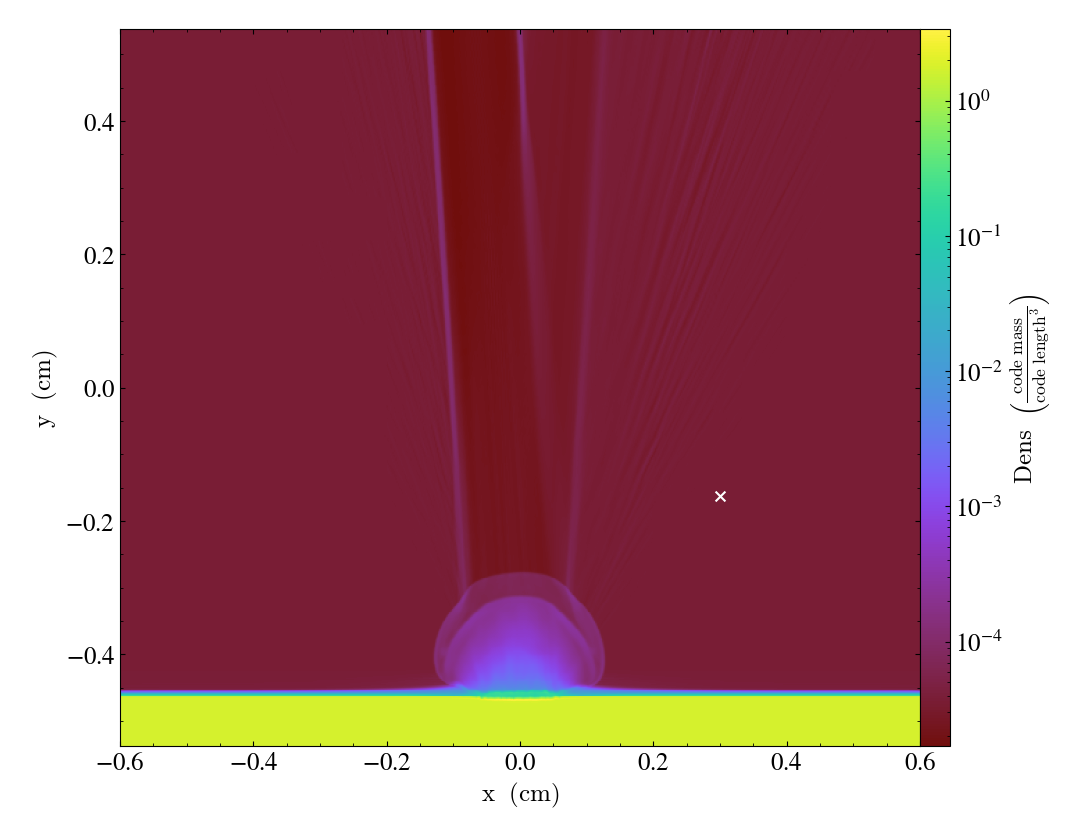

In [4]:
# Find some points in the background to pull values from

background_pt = [0.3, 0.3, 0.0]
# background_pt = [-0.3, 0.5, 0.0]

rho_0 = pull_value_at_coord(background_pt,'dens',ds)

# looks good

In [5]:
# perform appropriate conversions to get the number density of ions and electrons

def make_ion_number_density(field, data):
    avogadro = 6.022e23
    ion_number_density = avogadro*data["flash","dens"]*data["flash","sumy"]
    return ion_number_density

def make_electron_number_density(field, data):
    avogadro = 6.022e23
    electron_number_density = avogadro*data["flash","dens"]*data["flash","ye"]
    return electron_number_density

ds.add_field(("flash", "idens"), function=make_ion_number_density, units="code_mass/code_length**3",sampling_type="cell") #technically the units are wrong here
ds.add_field(("flash", "edens"), function=make_electron_number_density, units="code_mass/code_length**3",sampling_type="cell") # same here

yt : [INFO     ] 2024-07-22 16:30:30,188 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-07-22 16:30:30,189 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-07-22 16:30:30,190 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-07-22 16:30:30,191 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-07-22 16:30:30,192 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800


edens at [0.3 0.3 0. ] code_length: [7.08375136e+18] code_mass/code_length**3



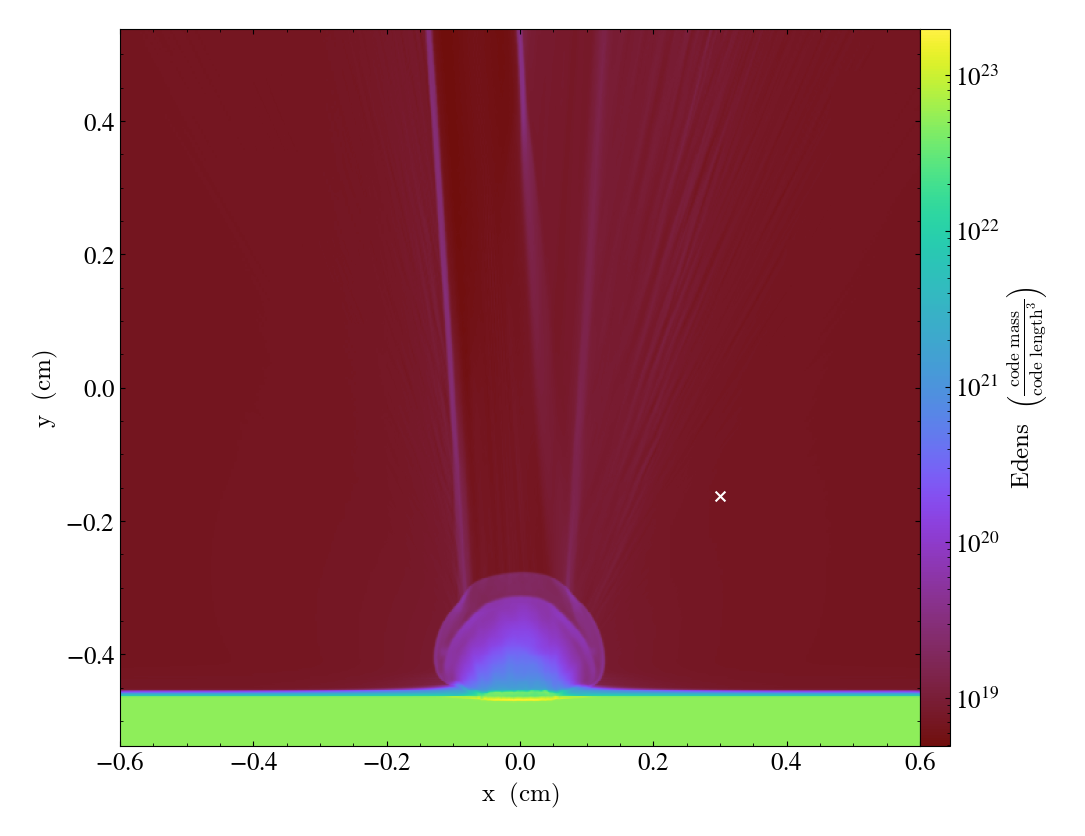

In [6]:
ne_0 = pull_value_at_coord(background_pt,'edens',ds)

yt : [INFO     ] 2024-07-22 16:30:30,606 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-07-22 16:30:30,606 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-07-22 16:30:30,608 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-07-22 16:30:30,608 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-07-22 16:30:30,609 Making a fixed resolution buffer of (('flash', 'magx')) 800 by 800


magx at [0.3 0.3 0. ] code_length: [149997.62759337] code_magnetic



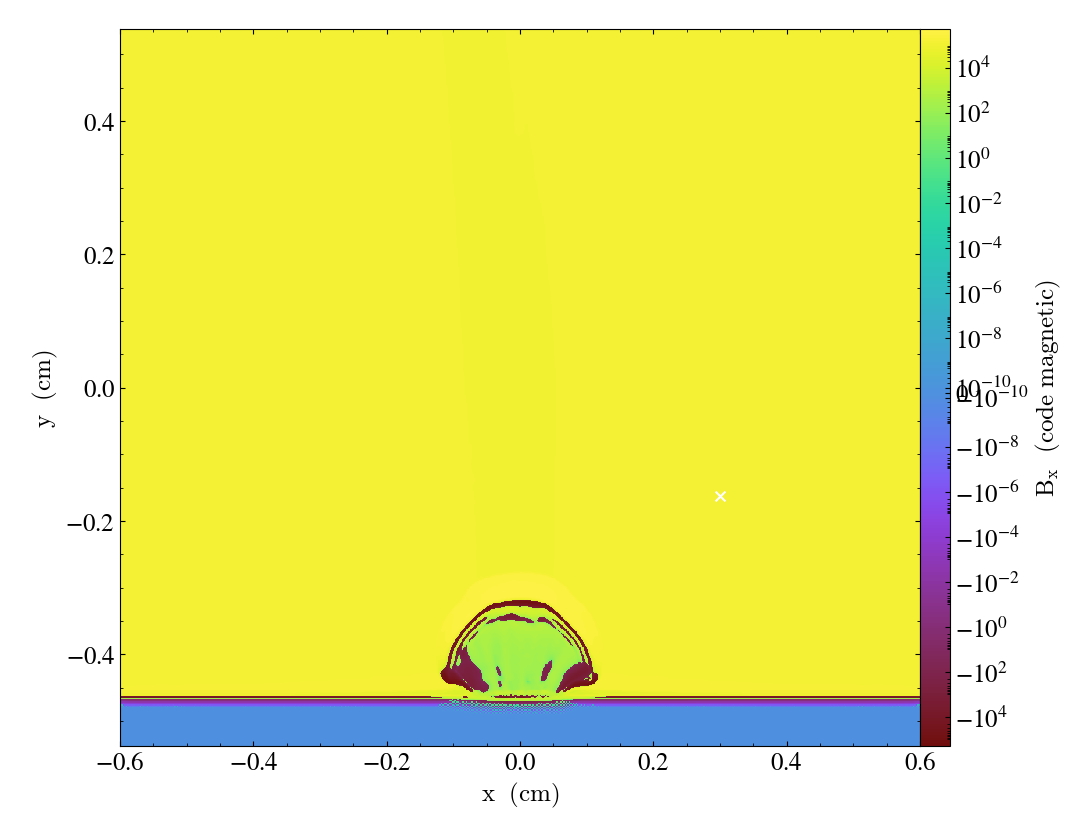

6932314.369654924


In [7]:
Bx_0 = pull_value_at_coord(background_pt,'magx',ds)

v_alfven = Bx_0.value[0]/np.sqrt(4*np.pi*rho_0.value[0])
print(v_alfven)

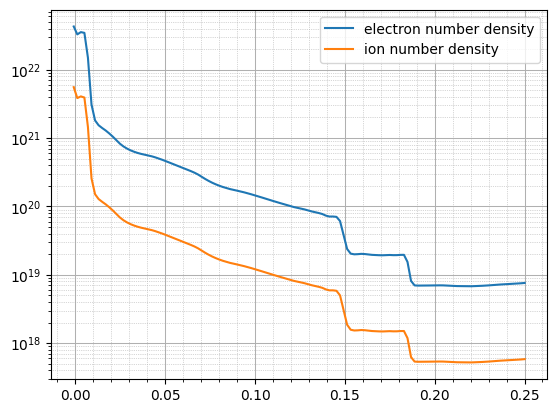

In [8]:
# Take a lineout of the number density to find where the target ends and where the piston begins
ray = ds.ray((0, 0.00, 0), (0, .25, 0))
y = np.array(ray[('flash','y')])
idens = np.array(ray[('flash','idens')])

edens = np.array(ray[('flash','edens')])
plt.semilogy(y, edens, label='electron number density')
plt.semilogy(y, idens, label='ion number density')
plt.legend()

from transform import pretty_plot
pretty_plot()

# based on this plot, it looks like the piston begins at y = 0.01

mach number is between 3.3287529961856044 and 15.47014091731735


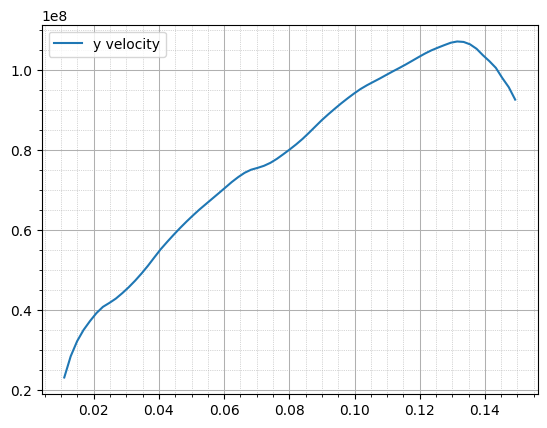

In [17]:
piston_ray = ds.ray((0, 0.01, 0), (0, .15, 0))
vely = np.array(piston_ray[('flash','vely')])
piston = np.array(piston_ray[('flash','y')])

plt.plot(piston, vely, label='y velocity')
pretty_plot()
plt.legend()

mach_number_max = np.max(vely)/v_alfven
mach_number_min = np.min(vely)/v_alfven

print(f"mach number is between {mach_number_min} and {mach_number_max}")